In [252]:
import pandas as pd
import numpy as np
from IPython.display import Image
import scipy.spatial.distance as spd
from mlflow import log_metric, log_param, start_run, end_run
from tqdm import tqdm_notebook as tqdm
import json
import matplotlib.pyplot as plt
import csv
# adjust dimensions of plot area to make it look better
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
######## PART 1 ########

In [3]:
"""
extracting the mean vectors and the covariance matrix.
have to reshape the mean vectors (dimensions - (1, 20)) 
since np.random.multivariate_normal() requires that the
mean vector be one-dimensional.
"""
neg_class_mean_vector = np.array(pd.read_csv('./hwk2_datasets/DS1_m_0.txt', header=None)).T.reshape(20)
pos_class_mean_vector = np.array(pd.read_csv('./hwk2_datasets/DS1_m_1.txt', header=None)).T.reshape(20)
cov_matrix = np.array(pd.read_csv('./hwk2_datasets/DS1_Cov.txt', header=None))

In [4]:
"""
generating the two classes (20 features each),
using the mean vectors and covariance matrix,
each containing 2000 examples
"""
pos_features_df = pd.DataFrame(data=np.random.multivariate_normal(pos_class_mean_vector, cov_matrix, size=2000))
neg_features_df = pd.DataFrame(data=np.random.multivariate_normal(neg_class_mean_vector, cov_matrix, size=2000))

In [5]:
"""
generating the class labels for the 2 classes
which will be added to the DataFrame made above
"""
pos_class_column = pd.Series([1 for x in range(2000)])
neg_class_column = pd.Series([0 for x in range(2000)])

In [6]:
"""
adding the columns with class labels to
the respective DataFrames for the 2 classes
"""
pos_class_df = pd.concat([pos_features_df, pos_class_column], axis=1, ignore_index=True)
neg_class_df = pd.concat([neg_features_df, neg_class_column], axis=1, ignore_index=True)

In [7]:
"""
extracting a 20% sample for the test set
from both the positive and negative classes
"""
test_df_pos_class = pos_class_df.sample(frac=0.2)
test_df_neg_class = neg_class_df.sample(frac=0.2)
test_df = pd.concat([test_df_pos_class, test_df_neg_class], ignore_index=True)
test_x = test_df.drop([20], axis=1)
test_y = test_df[20]

In [8]:
"""
for the valid set, getting those records 
from the total which are not present in 
the test set and getting a 25% sample from
that. a 25% sample from the (total-test set)
is equivalent to 20% of the total.
"""
valid_df_pos_class = pos_class_df.loc[~pos_class_df.index.isin(test_df_pos_class.index)].sample(frac=0.25)
valid_df_neg_class = neg_class_df.loc[~neg_class_df.index.isin(test_df_neg_class.index)].sample(frac=0.25)
valid_df = pd.concat([valid_df_pos_class, valid_df_neg_class], ignore_index=True)
valid_x = valid_df.drop([20], axis=1)
valid_y = valid_df[20]

In [9]:
"""
getting all records for both positive and
negative classes which are not a part of 
either the test set or valid set. combining
the resultant positive, negative class records
to obtain the training set.
"""
not_train_df_pos_class = pd.concat([test_df_pos_class, valid_df_pos_class])
train_df_pos_class = pos_class_df.loc[~pos_class_df.index.isin(not_train_df_pos_class.index)]

not_train_df_neg_class = pd.concat([test_df_neg_class, valid_df_neg_class])
train_df_neg_class = neg_class_df.loc[~neg_class_df.index.isin(not_train_df_neg_class.index)]

train_df = pd.concat([train_df_pos_class, train_df_neg_class], ignore_index=True)
train_x = train_df.drop([20], axis=1)
train_y = train_df[20]

In [10]:
"""
function to verify/check
the shapes of the DataFrames
"""
def check_shape(df, name):
    print(name, ":")
    print("Positive class:", df.loc[df[20] == 1].shape)
    print("Negative class:", df.loc[df[20] == 0].shape)
    print()

In [11]:
check_shape(test_df, "Test")
check_shape(valid_df, "Valid")
check_shape(train_df, "Train")

Test :
Positive class: (400, 21)
Negative class: (400, 21)

Valid :
Positive class: (400, 21)
Negative class: (400, 21)

Train :
Positive class: (1200, 21)
Negative class: (1200, 21)



In [ ]:
"""
generating csv files for the 
3 data sets for submission
"""
train_df.to_csv("Assignment2_260708548_DS1_train.csv")
valid_df.to_csv("Assignment2_260708548_DS1_valid.csv")
test_df.to_csv("Assignment2_260708548_DS1_test.csv")

In [12]:
######## PART 2 ########

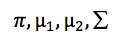

In [13]:
"""
Parameters for the GDA model
"""
Image(filename='./pics/gda_params.png')

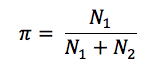

In [14]:
"""
Estimating pi
"""
Image(filename='./pics/gda_pi.png')

In [15]:
num_pos_class = train_df_pos_class.shape[0]
num_neg_class = train_df_neg_class.shape[0]
pi = num_pos_class/(num_pos_class+num_neg_class)

In [16]:
pi

0.5

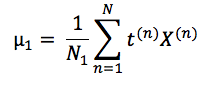

In [17]:
"""
Estimating mu_one
"""
Image(filename='./pics/gda_mu_one.png')

In [18]:
"""
since we already have the positive class
separately we don't need to go over the
combined positive and negative classes
"""
m1_data = (train_df_pos_class.drop([20], axis=1).sum(axis=0))/num_pos_class
mu_one = pd.DataFrame(data=m1_data)

In [244]:
print(np.array(mu_one))

[[1.90448793]
 [1.92699812]
 [1.98321371]
 [1.94851866]
 [1.8793009 ]
 [1.93669483]
 [1.91233549]
 [1.94111137]
 [1.90316005]
 [1.90109554]
 [1.93696062]
 [1.89503158]
 [1.92056465]
 [1.91106437]
 [1.91652309]
 [1.89194288]
 [1.92048877]
 [1.93360497]
 [1.91483675]
 [1.93488537]]


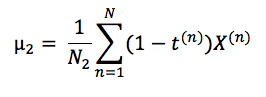

In [20]:
"""
Estimating mu_two
"""
Image(filename='./pics/gda_mu_two.png')

In [21]:
"""
once again, since we already have the negative class
separately we don't need to go over the
combined positive and negative classes
"""
m2_data = (train_df_neg_class.drop([20], axis=1).sum(axis=0))/num_neg_class
mu_two = pd.DataFrame(data=m2_data)

In [245]:
print(np.array(mu_two))

[[1.35987068]
 [1.37241143]
 [1.2879534 ]
 [1.25895574]
 [1.30020115]
 [1.33976699]
 [1.30238467]
 [1.33777338]
 [1.3427238 ]
 [1.39609594]
 [1.31655921]
 [1.3545217 ]
 [1.38293084]
 [1.33634738]
 [1.33458552]
 [1.31725253]
 [1.3191124 ]
 [1.36458183]
 [1.37080142]
 [1.33303209]]


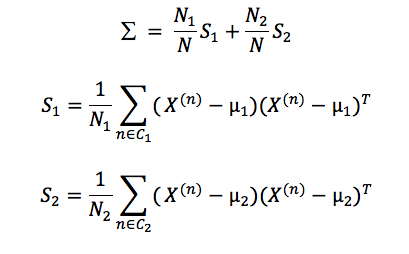

In [23]:
"""
Estimating sigma
"""
Image(filename='./pics/gda_sigma.png')

In [24]:
"""
provide the dataframe, mu vector
and number of entries to generate
the S(variance) matrix shown above in the picture
"""
def generate_variance_matrix(df, mu, num_entries):
    variance_df = pd.DataFrame(data=[[0 for i in range(20)] for j in range(20)])
    for idx, row in df.drop([20], axis=1).iterrows():
        row = pd.DataFrame(data=row)
        row.columns = [0]
        diff = row.subtract(mu)
        single_example_entry = diff.dot(diff.T)
        log_param("single_example_entry", type(single_example_entry))
        variance_df += single_example_entry
    
    variance_df = variance_df.divide(num_entries)
    return variance_df

In [25]:
s1_df = generate_variance_matrix(train_df_pos_class, mu_one, num_pos_class)
s2_df = generate_variance_matrix(train_df_neg_class, mu_two, num_neg_class)

In [27]:
s2_df

0         1         2         3         4         5         6   \
0   7.323414  4.875606  5.532969  4.512532  5.212350  5.480066  4.159715   
1   4.875606  6.238844  4.695953  3.619009  4.708486  4.942609  3.867869   
2   5.532969  4.695953  6.673003  4.249361  5.109296  5.982527  4.121139   
3   4.512532  3.619009  4.249361  5.257050  4.652617  3.869239  3.207939   
4   5.212350  4.708486  5.109296  4.652617  6.292731  4.712885  4.514522   
5   5.480066  4.942609  5.982527  3.869239  4.712885  6.120618  3.979873   
6   4.159715  3.867869  4.121139  3.207939  4.514522  3.979873  4.706431   
7   4.890491  3.391901  4.212694  3.798951  3.789002  4.326937  3.434760   
8   4.571662  3.775682  4.443001  2.981865  4.219107  4.298624  3.632222   
9   4.588027  4.358028  4.405076  3.582243  4.359141  4.708233  3.871235   
10  3.621271  2.898427  2.843748  2.342038  3.652938  2.568887  2.717855   
11  4.709684  4.113730  4.104068  3.694931  4.464089  4.237825  3.896018   
12  6.415309  5.191610  5.646600  5.294814  5.464388  5.640690  4.226292   
13  5.489015  4.459955  4.538734  4.153609  5.186380  4.353606  3.707478   
14  5.563835  4.880940  5.540706  4.228548  5.359305  5.242880  4.292861   
15  5.371332  4.599525  5.355373  4.413443  5.496051  5.405102  4.723352   
16  5.230875  5.023382  5.584614  4.076598  5.263288  5.289024  3.871076   
17  5.141095  4.465770  4.339991  3.915306  4.467031  4.353373  3.198624   
18  5.131638  4.864633  4.141418  3.326899  4.810309  4.231929  4.245436   
19  5.326244  4.688003  4.553983  5.308494  5.109627  4.635269  3.473263   

          7         8         9         10        11        12        13  \
0   4.890491  4.571662  4.588027  3.621271  4.709684  6.415309  5.489015   
1   3.391901  3.775682  4.358028  2.898427  4.113730  5.191610  4.459955   
2   4.212694  4.443001  4.405076  2.843748  4.104068  5.646600  4.538734   
3   3.798951  2.981865  3.582243  2.342038  3.694931  5.294814  4.153609   
4   3.789002  4.219107  4.359141  3.652938  4.464089  5.464388  5.186380   
5   4.326937  4.298624  4.708233  2.568887  4.237825  5.640690  4.353606   
6   3.434760  3.632222  3.871235  2.717855  3.896018  4.226292  3.707478   
7   5.527845  3.278792  4.553120  2.279412  4.405370  5.738974  4.684663   
8   3.278792  4.573201  4.209125  2.832768  3.705871  4.575233  4.289529   
9   4.553120  4.209125  6.595631  2.835801  4.196245  6.244762  4.599608   
10  2.279412  2.832768  2.835801  3.113733  2.611998  3.299355  3.568427   
11  4.405370  3.705871  4.196245  2.611998  4.805911  5.465530  4.530729   
12  5.738974  4.575233  6.244762  3.299355  5.465530  8.518369  5.666163   
13  4.684663  4.289529  4.599608  3.568427  4.530729  5.666163  6.357838   
14  4.395943  4.517007  4.410513  3.241068  4.339427  5.673426  5.318930   
15  5.595533  4.730399  5.400161  3.286745  5.004774  5.941111  5.633221   
16  3.954837  4.663567  4.063594  3.207934  4.550383  5.250131  5.067079   
17  4.420128  3.695089  4.678399  2.834015  4.357026  5.685711  5.034058   
18  4.399000  3.938557  4.066786  3.471236  4.640229  5.420173  5.427515   
19  4.059344  3.668736  4.747923  3.023899  4.058744  6.794163  4.866886   

          14        15        16        17        18        19  
0   5.563835  5.371332  5.230875  5.141095  5.131638  5.326244  
1   4.880940  4.599525  5.023382  4.465770  4.864633  4.688003  
2   5.540706  5.355373  5.584614  4.339991  4.141418  4.553983  
3   4.228548  4.413443  4.076598  3.915306  3.326899  5.308494  
4   5.359305  5.496051  5.263288  4.467031  4.810309  5.109627  
5   5.242880  5.405102  5.289024  4.353373  4.231929  4.635269  
6   4.292861  4.723352  3.871076  3.198624  4.245436  3.473263  
7   4.395943  5.595533  3.954837  4.420128  4.399000  4.059344  
8   4.517007  4.730399  4.663567  3.695089  3.938557  3.668736  
9   4.410513  5.400161  4.063594  4.678399  4.066786  4.747923  
10  3.241068  3.286745  3.207934  2.834015  3.471236  3.023899  
11  4.339427  5.004774  4.550383  4.

In [28]:
num_total_class = num_pos_class + num_neg_class
sigma = s1_df.multiply(num_pos_class/num_total_class) + s2_df.multiply(num_neg_class/num_total_class)

In [246]:
print(np.array(sigma))

[[7.59840774 5.20785619 5.85671238 4.78930008 5.51871038 5.85315423
  4.35433797 5.1185244  4.79703133 4.98741225 3.79097077 4.95635108
  6.82443269 5.73992882 5.82468038 5.64122369 5.52581221 5.4290984
  5.34334079 5.69867941]
 [5.20785619 6.49590024 5.04448545 3.94013108 5.01834981 5.2663658
  4.05479645 3.67195297 3.94251141 4.71138998 3.12892636 4.31595543
  5.57537399 4.73028981 5.1593773  4.90921903 5.27741827 4.78141125
  5.06114541 5.03159332]
 [5.85671238 5.04448545 7.05501344 4.55368813 5.43098401 6.31743237
  4.36646124 4.52795856 4.68913797 4.81071669 3.05341288 4.35294623
  6.06518134 4.86130305 5.86828577 5.70014032 5.89932523 4.68671974
  4.42753595 4.87876022]
 [4.78930008 3.94013108 4.55368813 5.45960546 4.89765187 4.17438477
  3.41003683 4.07347946 3.18246949 3.96398215 2.51562644 3.8639123
  5.59182769 4.45132538 4.50642715 4.74082178 4.30922029 4.20597687
  3.56399274 5.54906346]
 [5.51871038 5.01834981 5.43098401 4.89765187 6.57612787 5.01483676
  4.7009185  3.9980

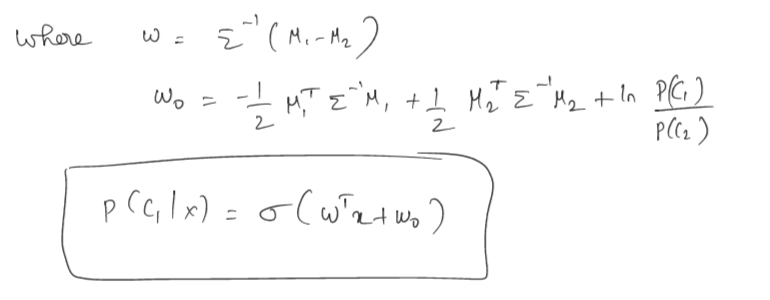

In [30]:
"""
GDA model
"""
Image(filename='./pics/gda_model.png')

In [247]:
"""
Finding w
"""
sigma_inv = pd.DataFrame(data=np.linalg.inv(sigma))
w = sigma_inv.dot(mu_one-mu_two)
print(np.array(w))

[[-14.40185658]
 [  8.55290681]
 [  5.7159651 ]
 [  2.88677339]
 [  9.53856629]
 [  4.25870661]
 [-16.49475443]
 [ 23.90136173]
 [ 28.73674712]
 [ -9.33763317]
 [ 13.07550527]
 [ 12.09740187]
 [-15.31718328]
 [-12.55588951]
 [  5.56176548]
 [-12.93945828]
 [-29.0685875 ]
 [  6.8006247 ]
 [  0.23285491]
 [  5.07158619]]


In [49]:
"""
Finding w0
"""
w0_part1 = mu_one.T.dot(sigma_inv).dot(mu_one).divide(-2)
w0_part2 = mu_two.T.dot(sigma_inv).dot(mu_two).divide(2)
w0_part3 = np.log(pi/(1-pi))
w0 = w0_part1 + w0_part2 + w0_part3

In [248]:
print(np.array(w0))

[[-26.95486584]]


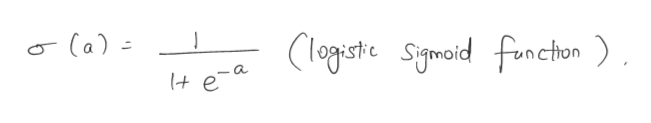

In [35]:
"""
Applying the logistic sigmoid function.
'a' = wT . x + w0 (from the picture above)
"""
Image(filename='./pics/logistic_sigmoid.png')

In [117]:
"""
Apply the logistic sigmoid function to the
input to get the prediction for the class.
"""
def get_class1_prob(w, w0, x):
    product = w.T.dot(x)
    product = product.values[0][0]
    w0 = w0[0][0]
    sigmoid_input = float(product + w0)
    denominator = 1 + np.e**(sigmoid_input*(-1))
    return 1/denominator

In [238]:
"""
Finding the predictions
for the test set
"""
two_test_predictions = []
for idx in range(test_df.shape[0]):
    x = test_df[idx:idx+1].drop([20], axis=1)
    test_pred = get_class1_prob(w, w0, x.T)
    print(test_pred)
    if test_pred < 0.5:
        test_pred = 0
    else:
        test_pred = 1
        
    two_test_predictions.append(test_pred)

In [243]:
# with open("DS1_test_predictions.csv",'w') as resultFile:
#     wr = csv.writer(resultFile, dialect='excel', delimiter='\n')
#     wr.writerow(test_raw_values)

In [173]:
def find_attr_confusion_matrix(dataset_predictions, dataset_y):
    confusion_dict = {"true_pos": 0, "true_neg": 0, "false_pos": 0, "false_neg": 0}
    dataset_y_list = list(dataset_y)
    for prediction, target in zip(dataset_predictions, dataset_y_list):
        if target == 1 and prediction == 1:
            confusion_dict["true_pos"] += 1
        
        elif target == 1 and prediction == 0:
            confusion_dict["false_neg"] += 1
        
        elif target == 0 and prediction == 1:
            confusion_dict["false_pos"] += 1
        
        elif target == 0 and prediction == 0:
            confusion_dict["true_neg"] += 1
    
    return confusion_dict

In [174]:
def find_accuracy(dataset_predictions, dataset_y):
    dataset_y_list = list(dataset_y)
    num_correct_classif = 0
    for prediction, target in zip(dataset_predictions, dataset_y_list):
        if prediction == target:
            num_correct_classif += 1
    
    return num_correct_classif/len(dataset_y_list)

In [175]:
def find_precision(confusion_dict):
    return confusion_dict["true_pos"]/(confusion_dict["true_pos"] + confusion_dict["false_pos"])

In [176]:
def find_recall(confusion_dict):
    return confusion_dict["true_pos"]/(confusion_dict["true_pos"] + confusion_dict["false_neg"])

In [177]:
def find_f1_measure(measure_prec, measure_recall):
    return 2*measure_prec*measure_recall/(measure_prec + measure_recall)

In [178]:
two_test_accuracy = find_accuracy(two_test_predictions, test_y)

In [179]:
two_confusion_dict = find_attr_confusion_matrix(two_test_predictions, test_y)

In [180]:
two_confusion_dict

{'false_neg': 16, 'false_pos': 16, 'true_neg': 384, 'true_pos': 384}

In [181]:
two_test_precision = find_precision(two_confusion_dict)

In [182]:
two_test_recall = find_recall(two_confusion_dict)

In [183]:
two_test_f1_measure = find_f1_measure(two_test_precision, two_test_recall)

In [184]:
log_metric("2. Test Accuracy ", two_test_accuracy)
log_metric("2. Test Precision", two_test_precision)
log_metric("2. Test Recall", two_test_recall)
log_metric("2. Test F1 Measure", two_test_f1_measure)

In [185]:
print("2. Test Accuracy ", two_test_accuracy)
print("2. Test Precision", two_test_precision)
print("2. Test Recall", two_test_recall)
print("2. Test F1 Measure", two_test_f1_measure)

2. Test Accuracy  0.96
2. Test Precision 0.96
2. Test Recall 0.96
2. Test F1 Measure 0.96


In [ ]:
######## PART 3 ########
# start_run()

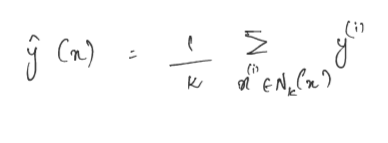

In [186]:
"""
Prediction in k-NN
"""
Image(filename='./pics/k-NN_classif.png')

In [187]:
"""
getting the sorted distances against the
training input for 1 example from the dataset
"""
def dataset_ex_sorted_distances(dataset_example, train_x):
    distances = []
    for j in range(train_x.shape[0]):
        train_example = train_x[j:j+1]
        distances.append(spd.euclidean(dataset_example, train_example))

    distances_df = pd.DataFrame(data=distances)
    sorted_dist = distances_df.sort_values(by=[0])
    return sorted_dist

In [188]:
"""
finding the average class based on the
specific example's sorted distances list
"""
def find_avg_class(train_df, sorted_dist):
    indices = list(sorted_dist.index)
    avg_class = 0
    for idx in indices:
        avg_class += int(train_df[idx:idx+1][20])

    avg_class = avg_class/len(indices)
    if avg_class < 0.5:
        avg_class = 0
    else:
        avg_class = 1

    return avg_class

In [189]:
"""
find the sorted distances against the
training input for EACH of the examples
from the dataset
"""
def find_dataset_distances(dataset_x, train_x):
    all_dataset_sorted_dist = []
    for i in tqdm(range(dataset_x.shape[0])):
        dataset_example = dataset_x[i:i+1]
        sorted_distances = dataset_ex_sorted_distances(dataset_example, train_x)
        all_dataset_sorted_dist.append(sorted_distances)

    # list of dataframes
    return all_dataset_sorted_dist

In [190]:
"""
finding the predictions for all examples
from the dataset for a specific value of k (k-NN)
"""
def find_dataset_predictions(all_dataset_distances, dataset_x, num_nearest_nbs):
    dataset_predictions = []
    for i in range(dataset_x.shape[0]):
        dataset_example_distances = all_dataset_distances[i]
        dataset_example_neighbors = dataset_example_distances[:num_nearest_nbs]
        neighbors_avg_class = find_avg_class(train_df, dataset_example_neighbors)
        dataset_predictions.append(neighbors_avg_class)

    return dataset_predictions

In [191]:
### TIME INTENSIVE ###
all_valid_sorted_dist = find_dataset_distances(valid_x, train_x)

In [209]:
"""
creating a list which stores the
different values of k (k-NN)
"""
diff_nbs = []
nbs = 50
while nbs < len(list(train_y)): 
    diff_nbs.append(nbs)
    nbs += 200
    
"""
stores the predictions for the
valid set for each value of k
"""
valid_neighbors_predictions = {}
diff_nbs
# log_param("Different k values", diff_nbs)

[50, 250, 450, 650, 850, 1050, 1250, 1450, 1650, 1850, 2050, 2250]

In [ ]:
### DON'T RUN THIS! EVEN MORE TIME INTENSIVE ###
# for num_nearest in tqdm(diff_nbs):
#     valid_predictions = find_dataset_predictions(all_valid_sorted_dist, valid_x, num_nearest)
#     valid_neighbors_predictions[num_nearest] = valid_predictions

In [ ]:
# with open('valid_neighbors_predictions.json', 'w') as f:
#     json.dump(valid_neighbors_predictions, f)

In [210]:
with open('valid_neighbors_predictions.json') as json_data:
    valid_neighbors_predictions = json.load(json_data)

In [219]:
best_f1_measure = 0
best_num_nearest = 0
f1_measures = []
count = 0
for num_nearest in diff_nbs:
    confusion_dict = find_attr_confusion_matrix(valid_neighbors_predictions[str(num_nearest)], valid_y)
#     print(valid_neighbors_predictions[num_nearest])
    measure_prec = find_precision(confusion_dict)
    measure_recall = find_recall(confusion_dict)
    f1_measure = find_f1_measure(measure_prec, measure_recall)
    f1_measures.append(f1_measure)
    if f1_measure > best_f1_measure:
        best_f1_measure = f1_measure
        best_num_nearest = num_nearest

In [220]:
perf_df = pd.DataFrame({'k': diff_nbs, 'f1_measure': f1_measures})

In [221]:
perf_df

f1_measure     k
0     0.584498    50
1     0.551546   250
2     0.551461   450
3     0.563725   650
4     0.564103   850
5     0.567961  1050
6     0.556650  1250
7     0.553506  1450
8     0.563482  1650
9     0.562123  1850
10    0.560680  2050
11    0.557023  2250

In [249]:
perf_df.to_csv('f1_measure_for_different_k.csv')

In [222]:
best_num_nearest, best_f1_measure

(50, 0.5844980940279542)

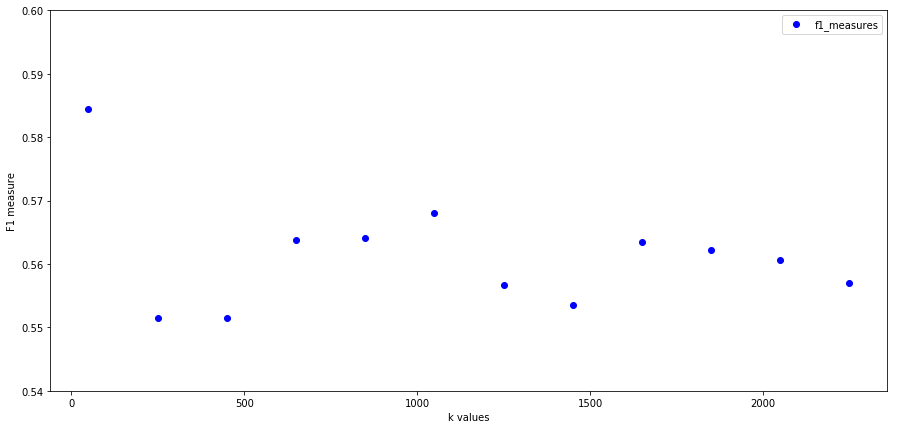

In [253]:
# plotting the output data points from the training data
# set versus the model found from the closed-form solution
plt.plot(perf_df['k'], perf_df['f1_measure'], 'bo', label='f1_measures')
# plt.plot(x_values_for_plot, find_predictions(plot_matrix, params_vector), 'r', label='Predictions')
plt.xlabel('k values')
plt.ylabel('F1 measure')
plt.ylim(0.54,0.6)
plt.legend()
plt.show()

In [ ]:
###### 3.(b) ######

In [224]:
all_test_sorted_dist = find_dataset_distances(test_x, train_x)
test_predictions = find_dataset_predictions(all_test_sorted_dist, test_x, best_num_nearest)
test_accuracy = find_accuracy(test_predictions, test_y)
test_confusion_dict = find_attr_confusion_matrix(test_predictions, test_y)
test_precision = find_precision(test_confusion_dict)
test_recall = find_recall(test_confusion_dict)
test_f1_measure = find_f1_measure(test_precision, test_recall)

In [225]:
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Measure:", test_f1_measure)

Test Accuracy: 0.55875
Test Precision: 0.5560859188544153
Test Recall: 0.5825
Test F1 Measure: 0.5689865689865691


In [228]:
log_metric("3.b Test Accuracy", test_accuracy)
log_metric("3.b Test Precision", test_precision)
log_metric("3.b Test Recall", test_recall)
log_metric("3.b Test F1 Measure", test_f1_measure)

In [229]:
# end_run()
# start_run()
log_param("best_f1_measure", best_f1_measure)
log_param("best_num_nearest", best_num_nearest)

In [254]:
print("best_f1_measure", best_f1_measure)
print("best_num_nearest", best_num_nearest)

best_f1_measure 0.5844980940279542
best_num_nearest 50
